# Error Mitigation using Clifford Data Regression on the IBM Utility Experiment

- Unmitigated data from the utility experiment:
https://www.nature.com/articles/s41586-023-06096-3
- Tensor network results from utility experiment as exact values (we'd need to run PP on the cluster for 127 qubits, 20 layers and machine precision)
- would be nice to have PP results (or any exp. values over time)


In [1]:
include("src/cpa.jl");

In [2]:
using DelimitedFiles

data_exp_unmit = Dict{Float64, Array{Float64, 1}}()
open("data/fig4b_experiment_unmit.txt", "r") do f
    for d in eachline(f)
        values = split(d, ",")
        key = parse(Float64, values[1])
        data = [parse(Float64, v) for v in values[2:end]]
        data_exp_unmit[key] = data
        #take mean for every angle
    end
end
IBM_unmitigated_vals = Vector{Float64}()
for i in keys(data_exp_unmit)
    push!(IBM_unmitigated_vals, mean(data_exp_unmit[i]))
end

# from Manuel's notebook
IBM_mitigated_vals = [1.01688859, 1.00387483, 0.95615886, 0.95966435, 0.83946763,
    0.81185907, 0.54640995, 0.45518584, 0.19469377, 0.01301832,0.01016334]
IBM_angles = [0.    , 0.1   , 0.2   , 0.3   , 0.4   , 0.5   , 0.6   , 0.7   , 0.8   , 1.    , 1.5707]

tn_vals = [9.99999254e-01,  9.99593653e-01,  9.95720077e-01,  9.88301532e-01,
        9.78553511e-01,  9.58023054e-01,  9.21986059e-01,  8.81726079e-01,
        8.49816779e-01,  8.24900527e-01,  7.91257641e-01,  7.37435202e-01,
        6.68573798e-01,  5.88096040e-01,  4.81874079e-01,  3.50316579e-01,
        2.26709331e-01,  1.39724659e-01,  7.86639143e-02,  4.24124371e-02,
        1.90595136e-02,  6.18879050e-03, -8.27168956e-04, -4.63372099e-03,
       -7.05202121e-03, -7.68387421e-03, -6.33121142e-03, -4.32594440e-03,
        6.52050191e-04,  1.72598340e-04,  5.64696020e-05, -7.70582375e-07]
tn_angles = LinRange(0, π/2, length(tn_vals));


In [3]:
angles = collect(keys(data_exp_unmit)) #theta_h

11-element Vector{Float64}:
 0.3
 1.0
 0.7
 0.0
 0.2
 0.8
 0.5
 0.1
 0.4
 1.5707
 0.6

In [4]:
IBM_unmitigated_vals

11-element Vector{Float64}:
  0.4188991191900761
  0.004107759335343423
  0.11944580478416555
  0.49038646460776864
  0.4552471452020139
  0.055064655494323766
  0.3061535376123831
  0.4889782663914668
  0.3622122171682965
 -0.001980699802309258
  0.20175539633925924

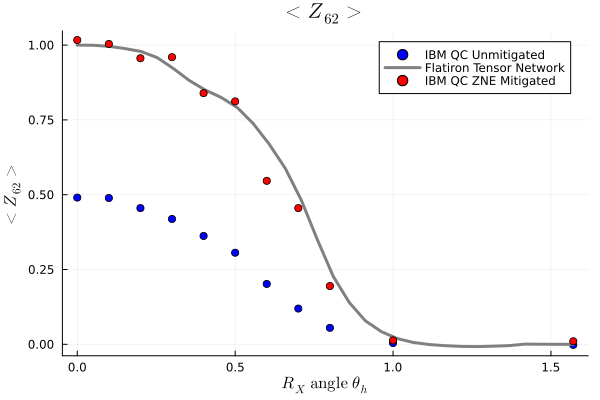

In [5]:
scatter(angles, IBM_unmitigated_vals, label="IBM QC Unmitigated", color=:blue, lw=2, xlabel=L" R_X\  \textrm{angle}\ \theta_h", ylabel=L"<Z_{62}>", title=L"<Z_{62}>", legend=:topright)
plot!(tn_angles, tn_vals, label="Flatiron Tensor Network", color="grey", linewidth=3)
scatter!(IBM_angles, IBM_mitigated_vals, label="IBM QC ZNE Mitigated", color="Red", ms=4)

## Our CDR procedure correcting IBM QC data

### Full run test

In [6]:
nq = 127 #number of qubits
topology = ibmeagletopology
nl = 2 #20
observable = PauliSum(nq)
add!(observable, :Z, 62) # different to Manuel
T = nl/20  #time resolution
h = 1.0 
min_abs_coeff = 1e-5; #training set (exact and noisy)
min_abs_coeff_exact = 0.0 #this should be 0 to get
min_abs_coeff_noisy = min_abs_coeff;
sigma_star = pi/20 #for our CPA methods
noise_kind = "gate_kickedising"
trotter = trotter_kickedising_setup(nq, nl, T,h; topology = topology)

trotter_ansatz_tfim(Gate[FrozenGate(PauliRotation([:Z, :Z], [1, 2]), parameter = -1.57), FrozenGate(PauliRotation([:Z, :Z], [1, 15]), parameter = -1.57), FrozenGate(PauliRotation([:Z, :Z], [2, 3]), parameter = -1.57), FrozenGate(PauliRotation([:Z, :Z], [3, 4]), parameter = -1.57), FrozenGate(PauliRotation([:Z, :Z], [4, 5]), parameter = -1.57), FrozenGate(PauliRotation([:Z, :Z], [5, 6]), parameter = -1.57), FrozenGate(PauliRotation([:Z, :Z], [5, 16]), parameter = -1.57), FrozenGate(PauliRotation([:Z, :Z], [6, 7]), parameter = -1.57), FrozenGate(PauliRotation([:Z, :Z], [7, 8]), parameter = -1.57), FrozenGate(PauliRotation([:Z, :Z], [8, 9]), parameter = -1.57)  …  PauliRotation([:X], [118]), PauliRotation([:X], [119]), PauliRotation([:X], [120]), PauliRotation([:X], [121]), PauliRotation([:X], [122]), PauliRotation([:X], [123]), PauliRotation([:X], [124]), PauliRotation([:X], [125]), PauliRotation([:X], [126]), PauliRotation([:X], [127])], Gate[FrozenGate(PauliRotation([:Z, :Z], [1, 2]), 

In [7]:
print("sigma_h = ", trotter.sigma_h, " sigma_J = ", trotter.sigma_J,"    pi/20 = ", pi/20)

sigma_h = 0.1 sigma_J = -1.5707963267948966    pi/20 = 0.15707963267948966

In [8]:
global_logger(UnbufferedLogger(stdout, SubInfo))
exact_expval_target, noisy_expval_target, corr_energy, rel_error_before, rel_error_after = full_run(trotter, sigma_star, noise_kind; min_abs_coeff, min_abs_coeff_noisy, observable = observable,num_samples = 5, record = true, cdr_method = "end", use_target = false, real_qc_noisy_data = IBM_unmitigated_vals[2])

[SubInfo] ready to ruuuuuummmble
[Error] Exception while generating log record in module Main at /home/julia/julia_scripts/pp-em/cdr/src/cpa.jl:755
[SubInfo] noisy_training_time_evolution done in 0.32 s
[SubInfo] cdr method end done in 3.06 s


(NaN, 0.004107759335343423, 0.00462632434585662, NaN, NaN)

# Smaller example (3 layers)

In [9]:
nq = 127 # number of qubits
nl = 3 # 20
T = nl/20  # time resolution
topology = ibmeagletopology

observable = PauliSum(nq)
add!(observable, :Z, 62) # different to Manuel

h_values = IBM_angles*nl/(2*T)
#h_values = h_values[1:2]
println("h_values = ", h_values)
noise_kind = "gate_kickedising"
depol_strength = 0.01
dephase_strength = 0.01

min_abs_coeff = 1e-10; # training set (exact and noisy)
min_abs_coeff_exact = 0.0 # this should be 0 to get
min_abs_coeff_noisy = min_abs_coeff;
sigma_star = pi/20; # for our CPA methods

h_values = [0.0, 1.0000000000000002, 2.0000000000000004, 3.0, 4.000000000000001, 5.0, 6.0, 6.999999999999999, 8.000000000000002, 10.0, 15.706999999999999]


In [10]:
collect_corr_energy = []
for (i, h) in enumerate(h_values)
    trotter = trotter_kickedising_setup(nq, nl, T, h;topology = topology)
    global_logger(UnbufferedLogger(stdout, MainInfo))
    training_set = training_set_generation_loose_perturbation(trotter; sample_function = "small", num_samples = 10)

    exact_expval_target, noisy_expval_target, corr_energy, rel_error_before, rel_error_after = full_run(
        trotter, sigma_star, noise_kind;
        min_abs_coeff = min_abs_coeff,
        min_abs_coeff_noisy = min_abs_coeff_noisy,
        training_set = training_set,
        observable = observable,
        record = true,
        cdr_method = "end",
        use_target = false,
        real_qc_noisy_data = IBM_unmitigated_vals[i]
    )
    append!(collect_corr_energy, corr_energy)
end

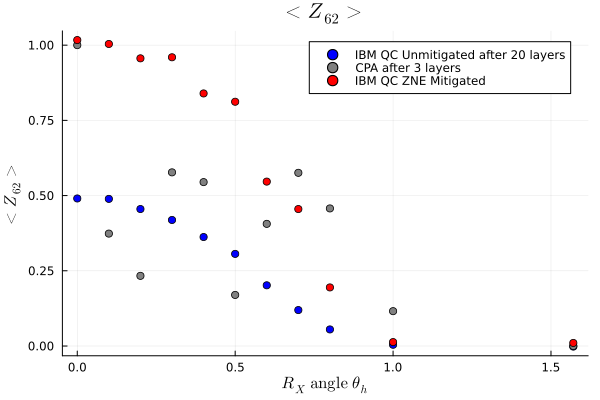

In [11]:
##plot the results (just to get an idea)
scatter(angles, IBM_unmitigated_vals, label="IBM QC Unmitigated after 20 layers", color=:blue, lw=2, xlabel=L" R_X\  \textrm{angle}\ \theta_h", ylabel=L"<Z_{62}>", title=L"<Z_{62}>", legend=:topright)
scatter!(h_values*2*T/nl, collect_corr_energy, label="CPA after 3 layers", color="grey", linewidth=3)
scatter!(IBM_angles, IBM_mitigated_vals, label="IBM QC ZNE Mitigated", color="Red", ms=4)